In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
import pandas as pd
import seaborn as sns
import dfply as df

#### Prep

In [55]:
cases = pd.read_csv(
    'csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv',
    header=0
)
cases = cases >> df.gather('date', 'count', df.columns_from(4))
cases['date'] = pd.to_datetime(cases['date'])
cases.head()

,Province/State,Country/Region,Lat,Long,date,count
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2
1,NaN,Japan,36.0000,138.0000,2020-01-22,2
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0


In [62]:
cases_g = cases >> df.group_by('date', 'Country/Region') >> df.summarise(count=df.X['count'].sum())

In [278]:
gr_argentina = select_gr.reset_index() >> df.mask(df.X['Country/Region'] == 'Argentina')

In [279]:
gr_argentina >> df.mask(df.X.date <= '2020-03-12') >> df.summarize(gr=df.X.gr.mean())

,gr
0,1.566589


In [230]:
21 ** (1/8)

1.4631114595026833

In [277]:
gr_arg = gr_argentina['count'].iloc[-1] ** (1 / gr_argentina.shape[0])

In [262]:
gr_arg

1.366401517936006

### Casos Argentina

In [281]:
gr_argentina = gr_argentina >> df.select(df.columns_from(2))

In [295]:
gr_argentina

,Country/Region,date,count,gr
0,Argentina,2020-03-03,1,1.000000
1,Argentina,2020-03-04,1,1.000000
2,Argentina,2020-03-05,1,2.000000
3,Argentina,2020-03-06,2,4.000000
4,Argentina,2020-03-07,8,1.500000
5,Argentina,2020-03-08,12,1.000000
6,Argentina,2020-03-09,12,1.416667
7,Argentina,2020-03-10,17,1.117647
8,Argentina,2020-03-11,19,1.000000
9,Argentina,2020-03-12,19,1.631579


In [292]:
dt = pd.date_range('2020-03-14', '2020-04-18')
fc_arg = pd.DataFrame.from_dict({
    'date': dt,
    'count': [31 * gr_arg ** d for d in range(0, 1 + (dt[-1] - dt[0]).days)]
})

### Evolucion

$$
\begin{align}
 \text{casos_hoy} &= \text{factor contagio} * \text{casos_ayer}  \\
 \text{casos_mañana} &= \text{factor_contagio} * \text{casos_hoy}  \\
 \text{casos_mañana} &= \text{factor_contagio} * \text{factor_contagio} * \text{casos_ayer} \\
 \text{casos_mañana} &= \text{factor_contagio}^2 * \text{casos_ayer} \\
 \text{casos_n_dias} &= \text{factor_contagio}^n * \text{casos_hoy} \\
\end{align}
$$



Factor contagio arg (a apartir de datos actuales):

In [428]:
print(gr_arg)

1.366401517936006


In [471]:
countries = ['Argentina', 'Brazil', 'Italy', 'Iran', 'Spain', 'China', 
             'US', 'United Kindom', 'Greece', 'France', 'Chile', 'Portugal',
             'Hungary', 'Denmark']

In [472]:
select_c = cases_g >> df.mask(df.X['Country/Region'].isin(countries))

In [473]:
gr_data = select_c >> (
    df.group_by('Country/Region') >>
    df.mask(df.X['count'] > 0) >>
    df.mutate(first_date=df.first(df.X['date']), last_date=df.last(df.X['date']),
              start_count=df.colmin(df.X['count']), end_count=df.colmax(df.X['count'])
            ) >>
    df.row_slice(0)
)
for k, r in gr_data.set_index('Country/Region').iterrows():
    print(k, (r.end_count / r.start_count) ** (1 / ((r.last_date - r.first_date).days + 1)))

Argentina 1.366401517936006
Brazil 1.343306494818955
Chile 1.407657933475101
China 1.100827861547379
Denmark 1.5190725046789015
France 1.1621591831967437
Greece 1.36158365544625
Hungary 1.252484501515308
Iran 1.433631554163371
Italy 1.2352831800539905
Portugal 1.3985639696474133
Spain 1.2261390046823422
US 1.1593037867001246


/home/march/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


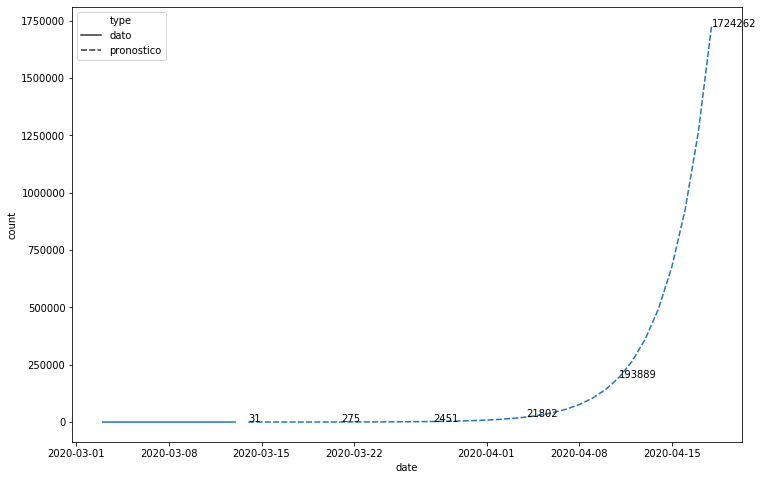

In [294]:
figure(figsize=(12, 8))
sns.lineplot(data=pd.concat([
    gr_argentina >> df.mutate(type='dato'), 
    fc_arg >> df.mutate(type='pronostico')
]), x='date', y='count', style='type', style_order=['dato', 'pronostico'])

sabados = pd.date_range('2020-03-14', '2020-04-18', freq='W-SAT')
for dt in sabados:
    v = fc_arg.set_index('date').loc[dt]['count']
    plt.text(dt, v + 100, str(int(v)))

### Simulaciones

50 0.36640151793600606


(array([737497., 737501., 737505., 737509., 737513., 737516., 737520.,
        737524., 737528., 737532.]), <a list of 10 Text xticklabel objects>)

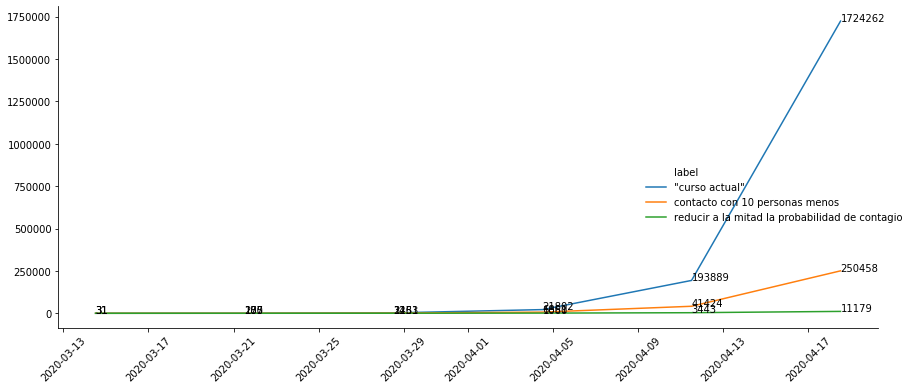

In [378]:
E = 50
p_orig = (gr_arg - 1) / E
E = 50
p = p_orig / 2
print(E, p * 100)
N0 = 31

fechas = pd.date_range(pd.datetime.today(), pd.to_datetime('2020-04-28'), freq='W-SAT', closed=None)
casos = pd.DataFrame({
    'date': f,
    'c': 31 * (1 + E * p) ** (f - fechas[0]).days,
    'label': l
}
    for (E, p, l) in [
        (50, p_orig, '"curso actual"'),
        (40, p_orig, 'contacto con 10 personas menos'),
        (50, p_orig / 2, 'reducir a la mitad la probabilidad de contagio')
    ]
    for f in fechas
)

g = sns.relplot(data=casos, x='date', y='c', hue='label', kind='line', aspect=1.8)
def add_text(data, color):
    for x, y in zip(data['date'], data['c']):
        plt.text(x, y+300, str(int(y)))
g.map_dataframe(add_text)
plt.xticks(rotation=45)

In [391]:
casos >> df.mutate(c=df.X.c.apply(lambda x: int(x))) >> df.spread('label', 'c')

,date,"""curso actual""",contacto con 10 personas menos,reducir a la mitad la probabilidad de contagio
0,2020-03-14 12:19:49.373226,31,31,31
1,2020-03-21 12:19:49.373226,275,187,100
2,2020-03-28 12:19:49.373226,2451,1133,326
3,2020-04-04 12:19:49.373226,21802,6851,1060
4,2020-04-11 12:19:49.373226,193889,41424,3443
5,2020-04-18 12:19:49.373226,1724262,250458,11179


### Con decaimiento

50 0.36640151793600606
(100,) [0, 7, 14, 21, 28, 35]


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text xticklabel objects>)

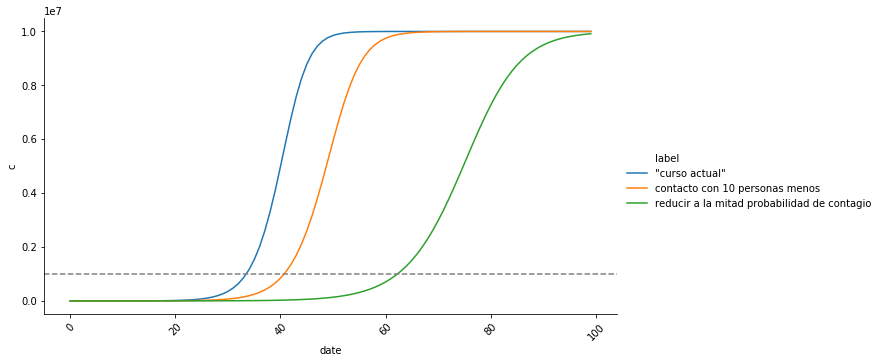

In [443]:
E = 50
p_orig = (gr_arg - 1) / E
E = 50
N = 10000000
p = p_orig / 2
print(E, p * 100)
N0 = 31

def c(N0, E, p, D, N):
    c = [N0]
    for d in range(1, D):
        e = E * (1 - c[-1] / N)
        c.append(c[-1] * (1 + e * p)) 
    return np.array(c)

#fechas = pd.date_range(pd.datetime.today(), pd.to_datetime('2020-04-28'), freq='W-SAT', closed=None)
#dias = [(f - fechas[0]).days for f in fechas]
casos = c(N0, E, p_orig, 100, N)

print(casos.shape, dias)
casos = pd.concat([
    pd.DataFrame.from_dict({
        'date': np.arange(100),
        'c': c(N0, E, p, 100, N),
        'label': label
    })
    for (E, p, label) in [
        (E, p_orig, '"curso actual"'),
        (E - 10, p_orig, 'contacto con 10 personas menos'),
        (E, p_orig / 2, 'reducir a la mitad probabilidad de contagio'),
    ]
])
g = sns.relplot(data=casos, x='date', y='c', kind='line', aspect=1.8, hue='label')
plt.axhline(1000000, color='grey', linestyle='--')
plt.xticks(rotation=45)

In [444]:
casos >> df.group_by('label') >> df.mask(df.X.c > 1000000) >> df.summarize(d0=df.first(df.X.dropna().date))

,label,d0
0,"""curso actual""",34
1,contacto con 10 personas menos,41
2,reducir a la mitad probabilidad de contagio,63


### Contando recuperaciones

50 0.36640151793600606


(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 <a list of 9 Text xticklabel objects>)

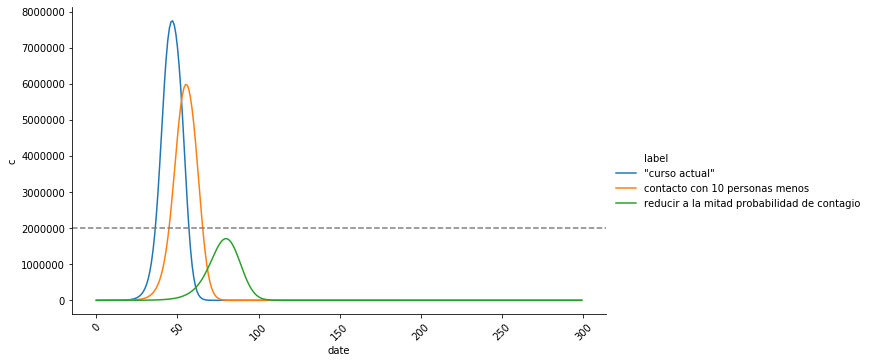

In [500]:
E = 50
p_orig = (gr_arg - 1) / E
E = 50
N = 10000000
RECOVERY_DAYS = 15 # https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus
p = p_orig / 2
print(E, p * 100)
N0 = 31
D = 300

def c(N0, E, p, D, N):
    c = [N0]
    n = [0]
    t = [N0]
    for d in range(1, D):
        e = E * (1 - t[-1] / N)
        n.append(c[-1] * (e * p))
        t.append(t[-1] * (1 + e * p))
        c.append(max(0, c[-1] + n[-1] - (0 if d < RECOVERY_DAYS else n[-RECOVERY_DAYS])))
    return np.array(c)

#fechas = pd.date_range(pd.datetime.today(), pd.to_datetime('2020-04-28'), freq='W-SAT', closed=None)
#dias = [(f - fechas[0]).days for f in fechas]
casos = c(N0, E, p_orig, 100, N)

casos = pd.concat([
    pd.DataFrame.from_dict({
        'date': np.arange(D),
        'c': c(N0, E, p, D, N),
        'label': label
    })
    for (E, p, label) in [
        (E, p_orig, '"curso actual"'),
        (E - 10, p_orig, 'contacto con 10 personas menos'),
        (E, p_orig / 2, 'reducir a la mitad probabilidad de contagio'),
    ]
])
g = sns.relplot(data=casos, x='date', y='c', kind='line', aspect=1.8, hue='label')
plt.axhline(2000000, color='grey', linestyle='--')
plt.xticks(rotation=45)

## Deprecado

In [64]:
countries = ['Argentina', 'Brazil', 'Italy', 'Iran', 'Spain', 'China']

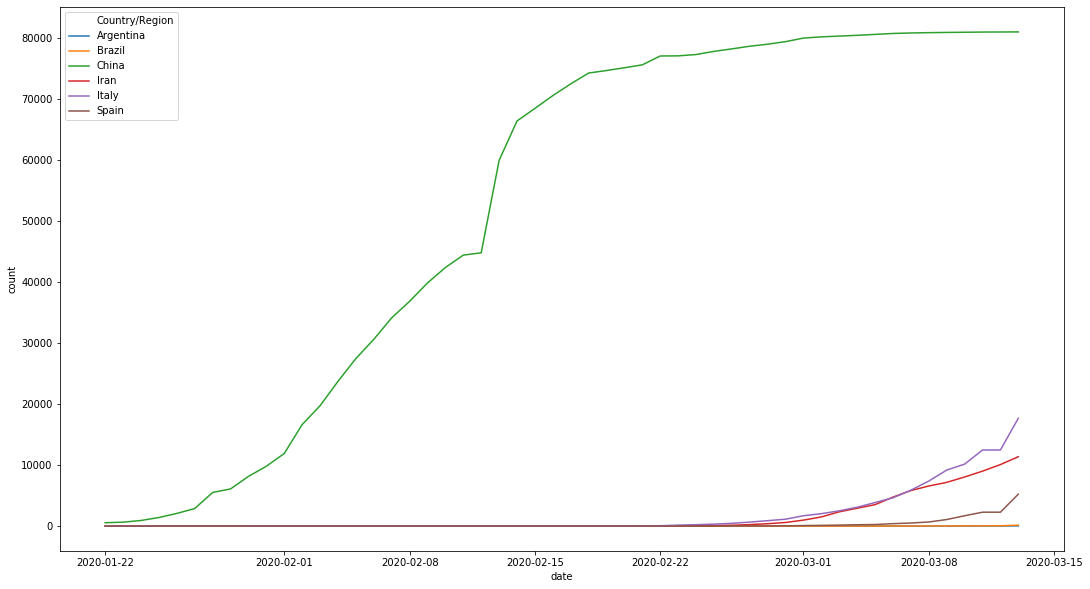

In [67]:
figure(figsize=(18, 10))
sns.lineplot(x='date', y='count', hue='Country/Region', 
             data=cases_g >> df.mask(df.X['Country/Region'].isin(countries)))

In [184]:
china_cases = cases_g >> df.mask(df.X['Country/Region'] == 'China')

In [188]:
china_cases.tail()

,Country/Region,date,count
5902,China,2020-03-09,80860
6027,China,2020-03-10,80887
6152,China,2020-03-11,80921
6277,China,2020-03-12,80932
6402,China,2020-03-13,80945


In [186]:
china_gr = china_cases.reset_index() >> df.mutate(gr=df.lead(df.X['count']) / df.X['count'])

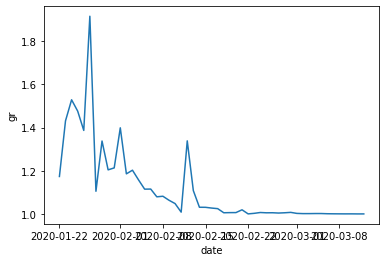

In [187]:
sns.lineplot(data=china_gr, x='date', y='gr')

In [161]:
iran_cases = cases_g >> df.mask(df.X['Country/Region'] == 'Iran')

In [180]:
iran_gr = iran_cases.reset_index() >> (
    df.mask(df.X['count'] > 0) >>
    df.mutate(gr=df.lead(df.X['count']) / df.X['count'])
)
iran_gr

,index,Country/Region,date,count,gr
28,3558,Iran,2020-02-19,2,2.500000
29,3683,Iran,2020-02-20,5,3.600000
30,3808,Iran,2020-02-21,18,1.555556
31,3933,Iran,2020-02-22,28,1.535714
32,4058,Iran,2020-02-23,43,1.418605
33,4183,Iran,2020-02-24,61,1.557377
34,4308,Iran,2020-02-25,95,1.463158
35,4433,Iran,2020-02-26,139,1.762590
36,4558,Iran,2020-02-27,245,1.583673
37,4683,Iran,2020-02-28,388,1.528351


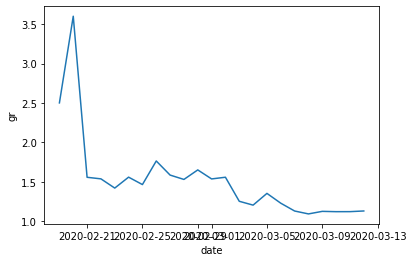

In [181]:
sns.lineplot(data=iran_gr, x='date', y='gr')

In [189]:
select_c = cases_g >> df.mask(df.X['Country/Region'].isin(countries))

In [194]:
select_gr = (select_c.reset_index() >> 
             df.group_by('Country/Region') >>
             df.mask(df.X['count'] > 0) >>
             df.mutate(gr=df.lead(df.X['count']) / df.X['count'])
            )

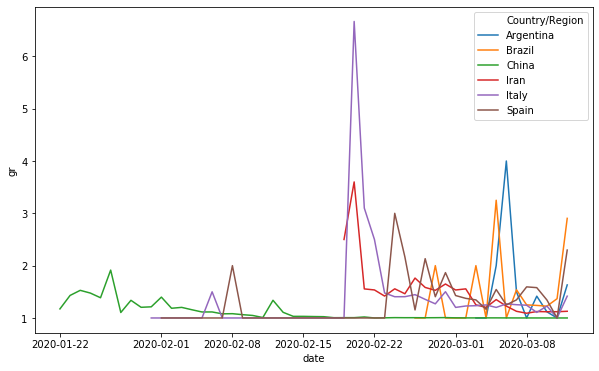

In [196]:
figure(figsize=(10, 6))
sns.lineplot(data=select_gr, x='date', y='gr', hue='Country/Region')

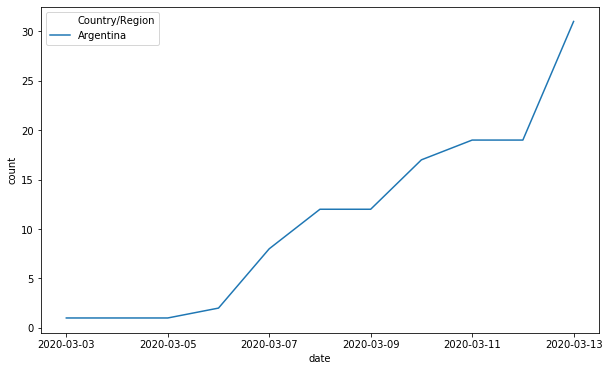

In [202]:
figure(figsize=(10, 6))
sns.lineplot(data=select_gr >> df.mask(df.X['Country/Region'] == 'Argentina'), 
             x='date', y='count', hue='Country/Region')

In [463]:
gr_data = select_c >> (
    df.group_by('Country/Region') >>
    df.mask(df.X['count'] > 0) >>
    df.mutate(first_date=df.first(df.X['date']), last_date=df.last(df.X['date']),
              start_count=df.colmin(df.X['count']), end_count=df.colmax(df.X['count'])
            ) >>
    df.row_slice(0)
)
for k, r in gr_data.set_index('Country/Region').iterrows():
    print(k, (r.end_count / r.start_count) ** (1 / ((r.last_date - r.first_date).days + 1)))

Argentina 1.366401517936006
Brazil 1.343306494818955
China 1.100827861547379
Iran 1.433631554163371
Italy 1.2352831800539905
Spain 1.2261390046823422


In [431]:
data = select_c

In [441]:
lims = (data >> df.mask(df.X['count'] > 0) >> df.group_by(df.X['Country/Region'])).iloc[[0, -1]]
lims = (data >> df.mask(df.X['date'] >= '2020-02-19', df.X['date'] <= '2020-02-29') >> df.group_by(df.X['Country/Region'])).iloc[[0, -1]]
start = lims.iloc[0]
end = lims.iloc[1]
gr = (end['count'] / start['count']) ** (1 / (end['date'] - start['date']).days)
gr

1.7668613463107405